In [2]:
import os
import re
import torch
import sklearn
import importlib
import pandas as pd
import numpy as np
import pickle as pickle
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from transformers import (AutoTokenizer, 
  AutoConfig, 
  AutoModelForSequenceClassification, 
  Trainer, 
  TrainingArguments, 
)

In [5]:
sys.path.append('../')

In [6]:
from load_data import *
from preprocessor import *
from dataset import *

In [27]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

## Load Data

In [9]:
def label_to_num(label):
    num_label = []
    with open('../dict_label_to_num.pkl', 'rb') as f:
        dict_label_to_num = pickle.load(f)
    for v in label:
        num_label.append(dict_label_to_num[v])
    return num_label


In [16]:
TAG_DICT = {'PER' : '인물', 'ORG' : '단체', 'DAT' : '날짜', 'LOC' : '장소', 'NOH' : '수량' , 'POH' : '기타'}
SUB_TOKEN1 = '→'
SUB_TOKEN2 = '☺'
OBJ_TOKEN1 = '§'
OBJ_TOKEN2 = '↘'

def preprocessing_dataset(dataset):
  subject_entity = []
  object_entity = []
  sen_data = []

  for s, i, j in zip(dataset['sentence'], dataset['subject_entity'], dataset['object_entity']):
    sub_info=eval(i)
    obj_info=eval(j)

    subject_entity.append(sub_info['word'])
    object_entity.append(obj_info['word'])
        
    sub_type = sub_info['type']
    sub_start = sub_info['start_idx']
    sub_end = sub_info['end_idx']

    obj_type = obj_info['type']
    obj_start = obj_info['start_idx']
    obj_end = obj_info['end_idx']

    sen = add_sep_tok(s, sub_start, sub_end, sub_type, obj_start, obj_end, obj_type)
    sen_data.append(sen)	
    
  out_dataset = pd.DataFrame({'id':dataset['id'],
		'sentence':sen_data,
		'subject_entity':subject_entity,
		'object_entity':object_entity,
		'label':dataset['label'],}
	)
  return out_dataset

In [17]:
def load_data(dataset_dir):
	pd_dataset = pd.read_csv(dataset_dir)
	dataset = preprocessing_dataset(pd_dataset)
	return dataset

def add_sep_tok(sen, sub_start, sub_end, sub_type, obj_start, obj_end, obj_type) :
	sub_mid = TAG_DICT[sub_type]
	obj_mid = TAG_DICT[obj_type]

	sub_start_tok = ' ' + SUB_TOKEN1 + ' ' + SUB_TOKEN2 + ' ' + sub_mid + ' ' + SUB_TOKEN2 + ' '
	sub_end_tok = ' ' + SUB_TOKEN1 + ' '
	obj_start_tok = ' ' + OBJ_TOKEN1 + ' ' + OBJ_TOKEN2 + ' ' + obj_mid + ' ' + OBJ_TOKEN2 + ' '
	obj_end_tok = ' ' + OBJ_TOKEN1 + ' '

	if sub_start < obj_start :
		sen = sen[:sub_start] +  sub_start_tok + sen[sub_start:sub_end+1] + sub_end_tok + sen[sub_end+1:]
		obj_start += 13
		obj_end += 13
		sen = sen[:obj_start] + obj_start_tok + sen[obj_start:obj_end+1] + obj_end_tok + sen[obj_end+1:]
	else :
		sen = sen[:obj_start] + obj_start_tok + sen[obj_start:obj_end+1] + obj_end_tok + sen[obj_end+1:]
		sub_start += 13
		sub_end += 13
		sen = sen[:sub_start] + sub_start_tok + sen[sub_start:sub_end+1] + sub_end_tok + sen[sub_end+1:]
	return sen

In [18]:
MODEL_NAME = 'klue/roberta-large'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# -- Device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# -- Raw Data
train_dataset = load_data("/opt/ml/project/RelationExtraction/data/train/train.csv")
train_label = label_to_num(train_dataset['label'].values)

# -- Preprocessor 
preprocessor = Preprocessor(tokenizer)

In [22]:
def tokenized_dataset(dataset, tokenizer, maxlen, preprocessor):
    entity_data = []
    sen_data = []
    for e01, e02, sen in zip(dataset['subject_entity'], dataset['object_entity'], dataset['sentence']):
        entity = e01 + ' [SEP] ' + e02
        entity = preprocessor(entity)
        entity_data.append(entity)
        sen = preprocessor(sen)
        sen_data.append(sen)

    tokenized_sentences = tokenizer(
        entity_data, # entity data (subject, object)
        sen_data, # sentence data
		return_tensors="pt",
		truncation=True,
		padding='max_length',
		max_length=maxlen,
        return_token_type_ids=False,
		add_special_tokens=True
	)
    return tokenized_sentences, entity_data, sen_data

In [23]:
tokenized_data, entity_data, sen_data = tokenized_dataset(train_dataset, tokenizer, 256, preprocessor)

In [26]:
entity_tokenized_data = []
for entity in tqdm(entity_data) :
    entity_tokenized_data.append(tokenizer.tokenize(entity))

In [28]:
entity_len = list(map(len, entity_tokenized_data))

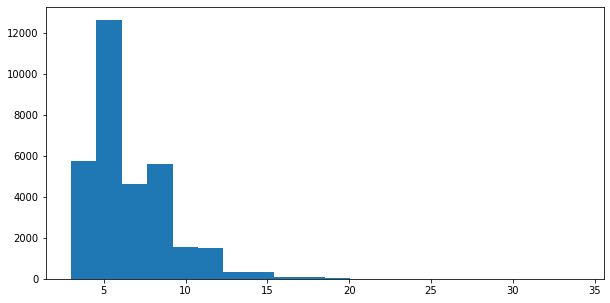

In [32]:
plt.figure(figsize = (10, 5))
plt.hist(entity_len, bins = 20)
plt.show()

In [33]:
entity_tokenized_data[0]

['비틀즈', '[SEP]', '조지', '해리', '##슨']

In [34]:
tokenizer.convert_tokens_to_string(entity_tokenized_data[0])

'비틀즈 [SEP] 조지 해리슨'

In [41]:
entity_padded_data = []

In [42]:
for entity in tqdm(entity_tokenized_data) :
    if len(entity) <= 10 :
        entity_padded = entity + ['[PAD]'] * (10 - len(entity))
    else :
        entity_padded = entity[:10]
    entity_padded_data.append(entity_padded)

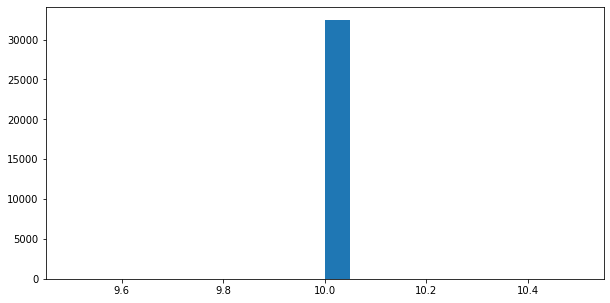

In [43]:
plt.figure(figsize = (10, 5))
plt.hist(list(map(len, entity_padded_data)), bins = 20)
plt.show()